In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from torchvision.models import vgg19, VGG19_Weights
import numpy as np


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

latent_dim = 100
batch_size = 64
image_size = 64   # DCGAN recomienda usar imágenes 64x64


Device: cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # [-1,1]
])

dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print("Tamaño del dataset:", len(dataset))


100%|██████████| 26.4M/26.4M [02:09<00:00, 204kB/s]   
100%|██████████| 29.5k/29.5k [00:00<00:00, 130kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.06MB/s]


Tamaño del dataset: 60000


In [5]:
class VGG19_Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Cargar VGG19 preentrenado
        vgg = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)
        vgg_features = vgg.features
        
        # Congelar pesos
        for param in vgg_features.parameters():
            param.requires_grad = False
        
        self.vgg_features = vgg_features
        
        # Nueva cabeza (después de VGG)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 2 * 2, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # FashionMNIST es 1 canal → convertimos a 3 canales
        x = x.repeat(1, 3, 1, 1)
        
        feat = self.vgg_features(x)
        out = self.classifier(feat)
        return out


In [6]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z)


In [7]:
G = Generator(latent_dim).to(device)
D = VGG19_Discriminator().to(device)


In [8]:
criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_D = optim.Adam(filter(lambda p: p.requires_grad, D.parameters()),
                         lr=2e-4, betas=(0.5, 0.999))


In [9]:
epochs = 30

G_losses = []
D_losses = []

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):

        imgs = imgs.to(device)
        batch_size = imgs.size(0)

        # Etiquetas reales y falsas
        real_labels = torch.ones((batch_size, 1), device=device)
        fake_labels = torch.zeros((batch_size, 1), device=device)

        # ------------------------
        #  Entrenar Discriminador
        # ------------------------
        optimizer_D.zero_grad()

        real_output = D(imgs)
        loss_real = criterion(real_output, real_labels)

        z = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = G(z)

        fake_output = D(fake_imgs.detach())
        loss_fake = criterion(fake_output, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # ------------------------
        #  Entrenar Generador
        # ------------------------
        optimizer_G.zero_grad()

        fake_output = D(fake_imgs)
        loss_G = criterion(fake_output, real_labels)
        loss_G.backward()
        optimizer_G.step()

    G_losses.append(loss_G.item())
    D_losses.append(loss_D.item())

    print(f"Epoch {epoch+1}/{epochs} | Loss D: {loss_D:.4f} | Loss G: {loss_G:.4f}")


Epoch 1/30 | Loss D: 0.7144 | Loss G: 2.1434
Epoch 2/30 | Loss D: 0.6112 | Loss G: 2.4679
Epoch 3/30 | Loss D: 0.8493 | Loss G: 1.8016
Epoch 4/30 | Loss D: 0.3607 | Loss G: 3.0089
Epoch 5/30 | Loss D: 0.7488 | Loss G: 2.5188
Epoch 6/30 | Loss D: 0.4141 | Loss G: 2.6881
Epoch 7/30 | Loss D: 0.4524 | Loss G: 3.6412
Epoch 8/30 | Loss D: 1.4233 | Loss G: 3.2378
Epoch 9/30 | Loss D: 1.2052 | Loss G: 6.3012
Epoch 10/30 | Loss D: 0.2549 | Loss G: 2.9799
Epoch 11/30 | Loss D: 0.3185 | Loss G: 3.2460
Epoch 12/30 | Loss D: 0.5089 | Loss G: 2.5231
Epoch 13/30 | Loss D: 0.1833 | Loss G: 3.4834
Epoch 14/30 | Loss D: 0.0927 | Loss G: 3.6364
Epoch 15/30 | Loss D: 1.1881 | Loss G: 5.7009
Epoch 16/30 | Loss D: 0.3890 | Loss G: 4.3203
Epoch 17/30 | Loss D: 0.6650 | Loss G: 4.3380
Epoch 18/30 | Loss D: 0.2099 | Loss G: 3.5431
Epoch 19/30 | Loss D: 0.3258 | Loss G: 3.8422
Epoch 20/30 | Loss D: 0.4065 | Loss G: 3.9933
Epoch 21/30 | Loss D: 1.0404 | Loss G: 2.7485
Epoch 22/30 | Loss D: 0.7226 | Loss G: 5.40

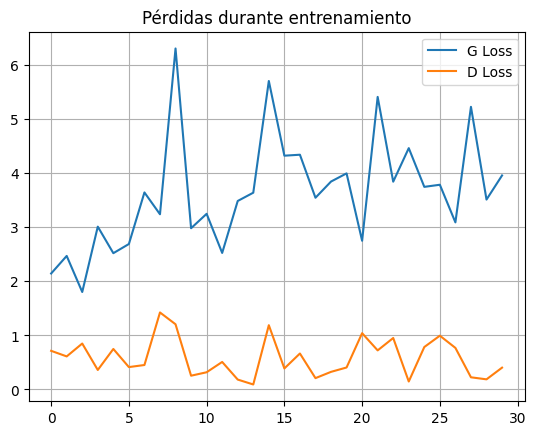

In [10]:
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.legend()
plt.title("Pérdidas durante entrenamiento")
plt.grid()
plt.show()


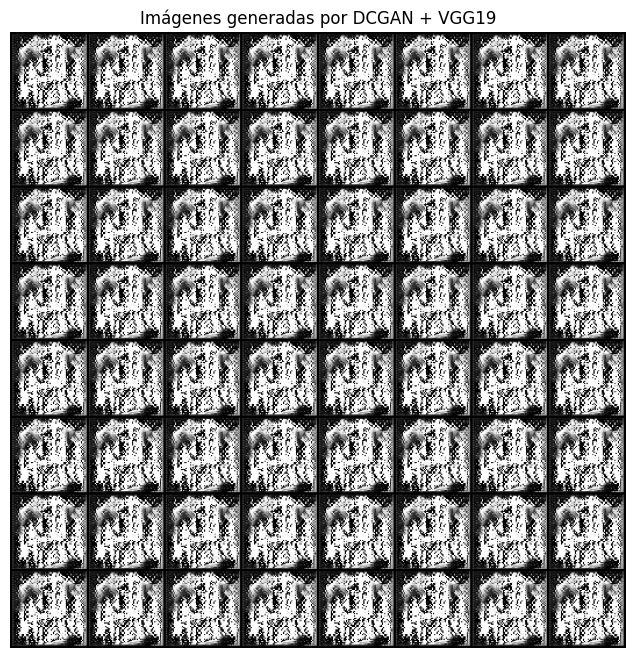

In [11]:
z = torch.randn(64, latent_dim, 1, 1, device=device)
samples = G(z).cpu().detach()

grid = make_grid(samples, nrow=8, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid, (1,2,0)))
plt.title("Imágenes generadas por DCGAN + VGG19")
plt.axis("off")
plt.show()
